# <center>Scaling XGBoost Hyper-Parameter Optimization</center>

<img src="images/swarm.png" width="450"/>

# Motivation:

After applying domain knowledge, intuition, and experimentation to carve out the space of all possible models, data scientists often run a final search over promising models to reach highest performance before deploying a model to production. 

This search is known as **hyper-parameter optimization (HPO)** since it searches over the parameters that are fixed during training. 
> [Hyper-parameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) either define the *architecture of the model* or the *settings of the learning algorithm.* 

HPO is an NP hard problem (i.e., no fast solution is known), and a naiive solution would be to search over the all possible parameters (e.g., grid search) but this is a pure exploration strategy and is in practice outdone by search strategies that balance exploration and exploitation (i.e. can leverage the knowledge from the search so far to inform where to look next). 

In this notebook we demonstrate the power of GPUs to accelerate HPO while also providing a learning aid for scaling concepts.

We leverage a simple yet powerful form of a search strategy called **Particle Swarm Optimization ( [PSO](https://en.wikipedia.org/wiki/Particle_swarm_optimization) )**. The idea of this approach is to randomly initialize particles in the search space and have them move around in a way that enables collaborative exploration and exploitation. A unique strength of particle swarms is their interpretability when combined with visualization of the particle trajectories (up to 4 hyper dimensions can be explored reliably this way encoded as 3D particle position position and 1D size). This interpretability is perhaps unique among other popular HPO tools [see [HyperBand](https://arxiv.org/abs/1603.06560), [BOHB](https://arxiv.org/abs/1807.01774) ] and can help build a data scientist's confidence in the best regions of the search space as well as provide hints for when the search region should be expanded (more in <a href='#particle-swarm'>Section 3.</a>)

# Table of Contents: 

1. [Multiple dataset ingestion](#dataset): synthetic, public [ airline, fashion-MNIST], BYOData ]
   * pre-process and visualize 


2. [Defining HPO Search Parameters + Ranges](#hyper-params)
   * within XGBoost model family


3. [Choice of Particle Swarm Strategy](#particle-swarm)
   - acceleration through approximation [ synch vs async swarms ]
   

4. [Definition of Dask Cluster](#define-cluster)
   * Scale-up on CPUs [ single node ] LocalCluster
   * Scale-up on GPUs [ single node ] LocalCUDACluster
   * Scale-out on GPUs [ multi-node ] KubeCluster

5. [Runing an HPO Experiment](#run-hpo)
   - interpretability though swarm visualization   
   - profiling via interactive dashboards    


6. [Accelerated Model Inference](#accelerated-inference)


7. [Saving Workflow/Experiment](#save-experiment)



# Library Imports:

In [1]:
# RAPIDS.ai libraries
import cudf
import cuml
import xgboost

# visualization libraries
import ipyvolume as ipv
import matplotlib.pyplot as plt

# common scientific / data analysis libraries
import numpy as np
import pandas as pd

In [2]:
# library imports for this HPO notebook
import data_utils
import swarm
import visualization as viz

# reload library modules/code without a kernel restart
import importlib; importlib.reload( swarm ); importlib.reload( data_utils ); importlib.reload( viz);
import warnings; warnings.filterwarnings('ignore')

# [ Optional ] Load Saved Experiment
To start a new experiment set `savedExperimentFilename = None`

Otherwise set its value to the path of a previously saved experiment [ yaml format ].

In [3]:
savedExperimentFilename = None # 'experiment.yaml'
exp, loadingSavedExperiment = data_utils.load_saved_experiment ( savedExperimentFilename )

starting new experiment


If you loaded an existing experiment you should jump straight to defining the cluster on which HPO will run. Compute clusters need to be rebuilt between experiments.
> <a href='#define-cluster'>Jump to Define Compute Cluster</a>

<a name='dataset'></a>
# PART 1 - Dataset Ingestion / Generation

-------

<center><a href='images/datasets.png'><img src="images/datasets.png" width="800"/></a></center>

## 1.1 - Ingest Real or Generate Synthetic Dataset
In this notebook you can try different hyper-parameter search methods using synthetic or real data.

In [4]:
datasetConfig = {  
    'datasetName'      : 'synthetic-swirl', #synthetic-helix', 'fashion-mnist', 'airline'
    'nSamples'         : 2000000,
    'localSaveDir'     : './data/',
    'datasetObject'    : None
}    

### Additional parameters are available for synthetic data

In [5]:
    if 'synthetic' in datasetConfig['datasetName']:
        coilType = datasetConfig['datasetName'].split('-')[1]
        syntheticDetails = {
            'coilType'            : coilType,
            'coilDensity'         : 18 if coilType == 'swirl' else 9,
            'coil1StDev'          : .3,
            'coil2StDev'          : .3,
            'nGuidePointsPerCoil' : 1000,
            'shuffleFlag'         : True,
            'randomSeed'          : 0,
        }
        datasetConfig.update(syntheticDetails)

        # warmup - JIT compile data generation GPU kernels
        warmupConfig = datasetConfig.copy();
        warmupConfig['nSamples'] = 2
        data_utils.Dataset ( warmupConfig )     

## 1.2 -  Build/Load Dataset

In [6]:
%%time
datasetConfig['datasetObject'] = data_utils.Dataset ( datasetConfig ) 
dataset = datasetConfig['datasetObject'] # create easy alias

CPU times: user 1.17 s, sys: 8.04 ms, total: 1.18 s
Wall time: 1.18 s


In [7]:
dataset.data.shape

(2000000, 3)

## 1.3 - Data Transformations

> **Splitting**: As is typical in machine learning workflows we need to split the dataset into a **train-set** and **test-set**. The test-set is unseen during training and model performance on the test-set is an indicator of how well our model(s) can generalize to future data [ also unseen during training ].

> **Scaling**: We can also apply standard scaling to each feature column of the dataset to ensure the data is numerically centered and ready for ingestion by an upstream model.
**Note**: This is an inplace operation which changes the value of the argument dataframe passed in without returning a value.


In [8]:
dataTransformsConfig =  { 
    'standardScaling'   : True,
    'percentTrainSplit' : .75,
    'shuffleAtSplit'    : True,
    'randomSeed'        : 0
}

> **Synthetic Splits**:  In the case of synthetic data, we use test with a distribution different than that of the train set in order to increase the difficulty of the problem and make it a challenge worthy of HPO. Specifically, we carve out the middle of the dataset along one of the synthetic dimensions [ x ], and assign these points to the test-set.

In [9]:
if 'synthetic' in datasetConfig['datasetName'] :    
    dataTransformsConfig['percentTrainSplit'] = .75 if datasetConfig['coilType'] == 'swirl' else .885
    dataTransformsConfig['samplesToSwap']     = int( dataset.data.shape[0] * .002 )
    assert ( dataset.data.shape[0] == datasetConfig['nSamples'])

## 1.3.1 - Apply Data Transforms

In [10]:
%%time
# fill missing values
missingIndicator = 0
dataset.data = dataset.data.fillna( missingIndicator )

CPU times: user 2.84 ms, sys: 3.5 ms, total: 6.34 ms
Wall time: 6.81 ms


In [11]:
%%time
if 'synthetic' not in datasetConfig['datasetName']:
    
    trainData, testData, \
    trainLabels, testLabels = cuml.train_test_split( dataset.data,  dataset.labels, 
                                                     train_size = dataTransformsConfig['percentTrainSplit'] )    
else:
    trainData, testData, \
    trainLabels, testLabels = data_utils.split_synthetic ( dataset.data, dataset.labels, 
                                                           percentTrain = dataTransformsConfig['percentTrainSplit'], 
                                                           samplesToSwap = dataTransformsConfig['samplesToSwap'] )

dataset.assign_dataset_splits ( trainData, testData, trainLabels, testLabels )

splitting synthetic dataset into train-set 75.0% and test-set 25.0%
> assigning middle span of data to test-set
> swapping 4000 samples between train-set and test-set
CPU times: user 715 ms, sys: 27.4 ms, total: 742 ms
Wall time: 742 ms


In [12]:
%%time
# apply standard scaling inplace to train-set and test-set
trainMeans, trainSTDevs, _ = data_utils.scale_dataframe_inplace ( dataset.trainData, label='train-set', datasetObject = dataset )
_,_,_ = data_utils.scale_dataframe_inplace ( dataset.testData, trainMeans, trainSTDevs, label='test-set', datasetObject = dataset )

applying [inplace] standard scaling to train-set data
applying [inplace] standard scaling to test-set data
CPU times: user 319 ms, sys: 517 µs, total: 320 ms
Wall time: 319 ms


## 1.4 - Visualize in 3D [ Embed ]

In [13]:
embeddingOptions = {
    'PCA'  : { 'method': 'PCA', 'sampleLimit': 200000 },
    'UMAP' : { 'method': 'UMAP', 'sampleLimit': 15000 },    
}

In [14]:
vizConfig = {
    'maxSamplesToPlot' : 200000,
    'embedding'        : embeddingOptions['UMAP']
}    

In [15]:
viz.plot_data_train_vs_test( dataset, vizConfig )

shuffling and decimating - train-set ... test-set ...
computing feature distributions in 0.63 seconds
elapsed time : 1.0013830661773682


<a name='hyper-params'></a>
# PART 2 - Defining HPO Search Parameters + Ranges

-------

## 2.1 - Explore XGBoost Hyper-Parameters 
Can you beat HPO? 

In [16]:
# flexible parameters -- read more @ https://xgboost.readthedocs.io/en/latest/parameter.html

manualXGBoostParams = { 
    'max_depth': 6,                     # default = 6             :: maximum depth of a tree
    'num_boost_round': 100,              # default = XXX           :: number of trees        
    'learning_rate': 0.3,               # default = 0.3           :: step size shrinkage between rounds, prevents overfitting
    'gamma': 0.,                        # default = 0             :: minimum loss reduction required to make a leaf node split, prevents overfitting
    'lambda': 1.,                       # default = 1             :: L2 regularizaiton term on weights, prevents overfitting
    'alpha': 0.,                        # default = 0             :: L1 regularization term on weights, prevents overfitting
    'tree_method': 'gpu_hist',          # default = 'gpu_hist'    :: tree construction algorithm
    'random_state' : 0 
}
# note: we'll inherit objective function [ & num_class ] from the dataset

In [17]:
trainedGPUModel, trainTimeGPU, inferenceTimeGPU = swarm.evaluate_manual_params( dataset, manualXGBoostParams )

train accuracy : 0.9329 in 0.7314 seconds
test  accuracy : 0.8526 in 0.0110 seconds


### 2.2 - [OPTIONAL] Diving Deeper into XGBoost

Comparison vs XGBoost CPU training & inference

In [18]:
runCPUComparison = False
if runCPUComparison:
    trainedCPUModel, trainTimeCPU, inferenceTimeCPU = swarm.evaluate_manual_params_CPU ( dataset, manualXGBoostParams, nCPUWorkers = 4 )
    print( f' train speedup     : {trainTimeCPU / trainTimeGPU:0.2f} ' )
    print( f' inference speedup : {inferenceTimeCPU / inferenceTimeGPU:0.2f} ' )

Feature Importance Plots

In [19]:
%%time
plotFeatureImportance = False
if plotFeatureImportance: 
    viz.plot_feature_importance( trainedGPUModel, importance_type='gain' )

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


Plot Decision Trees using GraphViz

In [20]:
%%time
modelDetailPlots = False
if modelDetailPlots: 
    viz.plot_first_N_trees( trainedGPUModel, nTrees = 2 )

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


## 2.3 - Setting HPO Parameters and Search Ranges

In [21]:
modelConfig = {
    'name'                  : 'XGBoost',    
                              # parameter        low    high    dtype 
    'tunableParam1'         : ['max_depth',      2,     15,    'int'   ],
    'tunableParam2'         : ['learning_rate',  .001,  2,     'float' ],
    'tunableParam3'         : ['gamma',          0.,    3.,    'float' ],

    'nTrees-ceiling'        : 2000, # see note below
    'early-stopping-rounds' : 250,  # see note below
    'randomSeed'            : 0,    
}

> **Note**: number of trees will be allowed to freely range between 0-2000 with an early stopping settting of 250

<a name='particle-swarm'></a>
# PART 3 - Choice of Particle Swarm Strategy

-------

## 3.1 - Define Particle Swarm

>"In computational science, particle swarm optimization (PSO) is a method that optimizes a problem by iteratively trying to improve a candidate solution with regard to a given measure of quality. It solves a problem by having a population of candidate solutions, here dubbed particles, and moving these particles around in the search-space according to simple mathematical formulae over the particle's position and velocity. Each particle's movement is influenced by its local best known position, but is also guided toward the best known positions in the search-space, which are updated as better positions are found by other particles. This is expected to move the swarm toward the best solutions." - [Wikipedia Article](https://en.wikipedia.org/wiki/Particle_swarm_optimization)

<img src='images/particle_logic.png' width='500px'>
<center><a href='https://en.wikipedia.org/wiki/Particle_swarm_optimization#Algorithm'>Particle Update Logic</a></center>   

## 3.2 - Blocking and Non-Blocking PSO Variants [ Sync vs Async ]
In a Synchronous Swarm **all particles wait for their peers to complete an update round** before deciding on the global best location in parameter space. 
> [Synchronous Swarm Video](https://drive.google.com/file/d/1emzCcxYM5C5ofCpFLgJ1qvBeKmiiTLCt/view?usp=sharing) 

Conversley in an Asynchronous Swarm particles update and read (a possibly stale value of) the global best without **without waiting** for their peers.
> [Asynchronous Swarm Video](https://drive.google.com/file/d/1GnbxiQAIMsT5qUiIRUGWwMLfMudNp0wX/view?usp=sharing)

As shown in the video links and in the figures below ( Sync on the left, Async on the right ), these concepts can be illustrated using dask task stream plots which are integrated into the RAPIDS runtime containers in the form of [jupyterlab-NVDashboard](https://github.com/rapidsai/jupyterlab-nvdashboard). 

In these plots GPU workers are shown as rows on the y-axis, and time is shown on the x-axis. The task rectangles shown in blue represent a sequence of particle evaluations tasks assigned/completed by each worker (per-row). Note that the task rectangles have varying length to indicate how long the particle evalutation needed to complete given its unique hyper-parameter settings. 

> Note: A good compromise between speed and convergence is to do an initial warmup round of Synchronization to allow every random particle to get at least one full evaluation before switching into fully Asynchronous mode.

<img src='images/sync_vs_async.png' width='800px'>

In [22]:
HPOConfig = { 
    'strategy'        : 'sync', # sync # async # async-random
    'nParticles'      : 16,
    'nEpochs'         : 3,
    'asyncWarmupFlag' : False,
    'randomSeed'      : 0
}

<a name='define-cluster'></a>
# PART 4 - Choice of Compute Cluster

-------

## <center> Scaling Compute with Kubernetes and Dask</center>

<img src='images/scaling.png' width='1000px'>

## 4.1 - Compute Cluster Selection

In [23]:
from dask.distributed import Client, LocalCluster # nWorkers = nCPU cores on a single node 
from dask_cuda import LocalCUDACluster            # nWorkers = nGPUs on a single node 
from dask_kubernetes import KubeCluster           # nWorkers = nGPUs across multiple node 

At this point the user has a choice of the following compute and scaling strategies 
   * Scale-up on CPUs [ single node ] LocalCluster
   * Scale-up on GPUs [ single node ] LocalCUDACluster
   * Scale-out on GPUs [ multi-node ] KubeCluster 
   
For multi-node scaling [ KubeCluster] requires that the notebooks is running on a Kubeflow Notebook Server on top of a Kubernetes cluster. See DeepOps installation instructions in the README.md.

In [24]:
computeConfig = {
    'clusterType'   : 'KubeCluster',  # [ LocalCluster ] or [ LocalCUDACluster] or [ KubeCluster ]
    'nWorkers'      : 4,
    'clientObject'  : None
}

## 4.2 - Cluster and Client Creation

In [25]:
if computeConfig['clusterType'] == 'KubeCluster':
    kubeIP = !echo $KUBEFLOW_CONTROLLER_SERVICE_HOST
    if kubeIP[0] == '':
        assert("Kubernetes cluster not found! [ launch notebook from a Kubeflow Notebook Server ]")
        workerSpecFilename = None
    else:
        workerSpecFilename = 'k8s_dask_worker.yaml'
        print(f'successfully detected kubernetes controller @ {kubeIP}')
        print(f'k8s+dask workers will run pod spec defined in [ {workerSpecFilename} ]')
        swarm.build_worker_spec( workerSpecFilename )
        !cat $workerSpecFilename

successfully detected kubernetes controller @ ['10.233.62.135']
k8s+dask workers will run pod spec defined in [ k8s_dask_worker.yaml ]

# k8s_dask_worker.yml
kind: Pod
metadata:
  labels:
    foo: bar
spec:
  restartPolicy: Never
  containers:
  - image: menev/hpo-rapids:0.1-0.11 # ericharper/rapids-dask-hpo:latest
    imagePullPolicy: IfNotPresent
    args: [dask-worker,  --nthreads, '1', --no-bokeh, --memory-limit, 6GB, --no-bokeh, --death-timeout, '60']
    name: dask
    resources:
      limits:
        cpu: "2"
        memory: 6G
        nvidia.com/gpu: 1
      requests:
        cpu: "2"
        memory: 6G
        nvidia.com/gpu: 1


In [26]:
if computeConfig['clusterType'] == 'LocalCluster': # single-node multi-CPU
    cluster = LocalCluster( ip = '', n_workers = computeConfig['nWorkers'])  
    
elif computeConfig['clusterType'] == 'LocalCUDACluster': # single-node multi-GPU 
    cluster = LocalCUDACluster( ip = '', n_workers = computeConfig['nWorkers'])
      
elif computeConfig['clusterType'] == 'KubeCluster': # multi-node multi-GPU
    cluster = KubeCluster.from_yaml( workerSpecFilename )

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://10.233.117.172:44211
distributed.scheduler - INFO -   dashboard at:                     :8787


In [27]:
cluster

In [28]:
computeConfig['clientObject'] = Client( cluster, asynchronous = True)

distributed.scheduler - INFO - Receive client connection: Client-62a5f766-225a-11ea-806b-8e06126e2312
distributed.core - INFO - Starting established connection


<a name='run-hpo'></a>
# PART 5 - Run HPO Experiment

-------

## 5.1 - Experiment Summary

In [29]:
if not loadingSavedExperiment:
    exp = { 'datasetConfig' : datasetConfig, 
            'dataTransformsConfig' : dataTransformsConfig,       
            'vizConfig' : vizConfig,
            'modelConfig' : modelConfig,
            'HPOConfig' : HPOConfig,
            'computeConfig' : computeConfig }
else:
    exp['computeConfig'] = computeConfig

In [30]:
exp

{'datasetConfig': {'datasetName': 'synthetic-swirl',
  'nSamples': 2000000,
  'localSaveDir': './data/',
  'datasetObject': <data_utils.Dataset at 0x7f79c3ddda90>,
  'coilType': 'swirl',
  'coilDensity': 18,
  'coil1StDev': 0.3,
  'coil2StDev': 0.3,
  'nGuidePointsPerCoil': 1000,
  'shuffleFlag': True,
  'randomSeed': 0},
 'dataTransformsConfig': {'standardScaling': True,
  'percentTrainSplit': 0.75,
  'shuffleAtSplit': True,
  'randomSeed': 0,
  'samplesToSwap': 4000},
 'vizConfig': {'maxSamplesToPlot': 200000,
  'embedding': {'method': 'UMAP', 'sampleLimit': 15000}},
 'modelConfig': {'name': 'XGBoost',
  'tunableParam1': ['max_depth', 2, 15, 'int'],
  'tunableParam2': ['learning_rate', 0.001, 2, 'float'],
  'tunableParam3': ['gamma', 0.0, 3.0, 'float'],
  'nTrees-ceiling': 2000,
  'early-stopping-rounds': 250,
  'randomSeed': 0},
 'HPOConfig': {'strategy': 'sync',
  'nParticles': 16,
  'nEpochs': 3,
  'asyncWarmupFlag': False,
  'randomSeed': 0},
 'computeConfig': {'clusterType': 'Ku

## 5.2 - Initialize Swarm with Experiment Settings

In [31]:
if HPOConfig['strategy'] == 'sync':
    expSwarm = swarm.SyncSwarm( exp )
    
elif HPOConfig['strategy'] == 'async':
    expSwarm = swarm.AsyncSwarm( exp )    
    
elif HPOConfig['strategy'] == 'async-random':
    expSwarm = swarm.RandomSearchAsync( exp )

! initializing SyncSwarm, with 16 particles, and 3 epochs


## 5.3 - <font color='red'>Run Swarm Experiment</font>

In [32]:
expSwarm.run_search()

scattering data to GPU workers...done scatter
  + persisting scattered data...done persist

   pID |      max_depth,  learning_rate,          gamma
     0 |              2,           0.00,           0.00 
     1 |              7,           1.87,           3.00 
     2 |             10,           1.86,           1.45 
     3 |             12,           1.68,           1.71 
     4 |             12,           0.35,           1.83 
     5 |              5,           1.66,           2.94 
     6 |             12,           0.42,           1.11 
     7 |              6,           0.88,           2.93 
     8 |              5,           0.48,           2.45 
     9 |             14,           0.99,           0.43 
    10 |             11,           0.99,           2.50 
    11 |             11,           1.33,           2.78 
    12 |             13,           1.75,           2.17 
    13 |              4,           1.72,           0.54 
    14 |             13,           1.32,           0.4

## 5.1 - Visualize Swarm

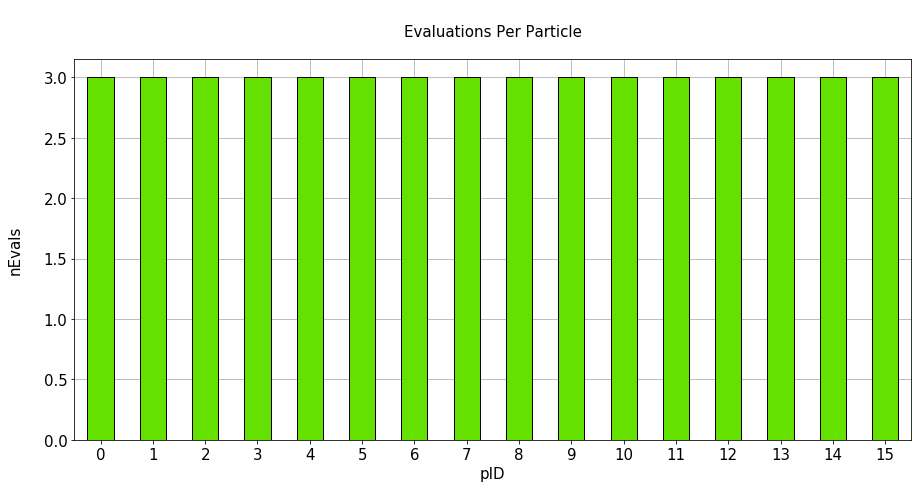

In [33]:
viz.plot_particle_evals( expSwarm )

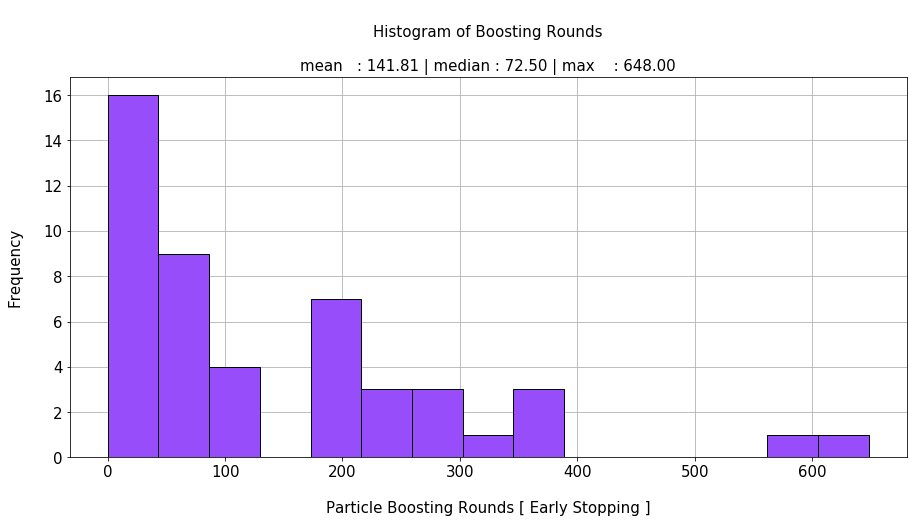

In [34]:
viz.plot_boosting_rounds_histogram( expSwarm )

In [35]:
viz.viz_top_particles( expSwarm )
# viz.viz_particle_trails(expSwarm, topN = 1) # for non-tabbed results

In [36]:
viz.viz_swarm( expSwarm, expSwarm.paramRanges)

# 6 - Accelerated Inference<a name='accelerated-inference'></a>

-------

In [ ]:
inferenceConfig = {
    'accelerateInference' : True
}
# TODO add FIL

# 7 - Save experiment

-------

In [ ]:
import yaml

In [ ]:
with open('experiment.yaml', 'w') as outfile:
    exp['datasetConfig']['datasetObject'] = None # update with parquet write
    exp['computeConfig']['clientObject'] = None
    yaml.dump(exp, outfile)

In [ ]:
!cat experiment.yaml

# Summary

-------

## Scale Up Results [ DGX-2 ]

<img src='images/synthetic_async.png' width = 500px></img>

# Future Work / Extensions

larger than single GPU memory datasets - dask_cudf + [ dask_xgboost or xgboost.dask ]

# References